In [2]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import classification_report, hamming_loss
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
import mlflow
import dagshub

dagshub.init(repo_owner='Shrijeet14', repo_name='toxic-comment-classification', mlflow=True)


mlflow.set_tracking_uri("https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=2b634af2-938c-4c36-bea4-b86fd3c5e4fb&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=14b6780818b08e2d3ad100dcfa47dbc908685c8716e5f160d12f66984bdad34f




Accessing as Shrijeet14

Initialized MLflow to track repo "Shrijeet14/toxic-comment-classification"

Repository Shrijeet14/toxic-comment-classification initialized!

In [6]:
df = pd.read_csv('processed_data.csv')

In [7]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category,word_count
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,24
1,aww ! match background colour seemingly stuck ...,0,0,0,0,0,0,0,11
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,21
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0,54
4,sir hero chance remember page ?,0,0,0,0,0,0,0,6


In [8]:
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category,word_count
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,24
1,aww ! match background colour seemingly stuck ...,0,0,0,0,0,0,0,11
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,21
3,make real suggestion improvement wondered sect...,0,0,0,0,0,0,0,54
4,sir hero chance remember page ?,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...
220673,jerome see never got around ! surprised looked...,0,0,0,0,0,0,0,49
220674,lucky bastard url heh famous kida envy congrats,0,0,0,0,0,0,0,8
220675,shame ! ! ! want speak gay romanian,0,0,0,0,0,0,0,8
220676,mel gibson nazi bitch make shity movie ha much...,1,0,1,0,1,0,-1,15


In [9]:
df.isna().sum()

,0
comment_text,2
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0
category,0
word_count,0


In [10]:
df = df[~df['comment_text'].isnull()]

In [11]:
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
from tqdm import tqdm

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
device = "/GPU:0" if tf.config.experimental.list_physical_devices('GPU') else "/CPU:0"
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
tqdm.pandas(desc="Processing Embeddings")

with tf.device(device):
    df['vector'] = df['comment_text'].progress_apply(lambda x: embed([x]).numpy()[0])

print(df.head())

Num GPUs Available: 1


Processing Embeddings: 100%|██████████| 220676/220676 [24:12<00:00, 151.91it/s]

                                        comment_text  toxic  severe_toxic  \
0  explanation edits made username hardcore metal...      0             0   
1  aww ! match background colour seemingly stuck ...      0             0   
2  hey man really trying edit war guy constantly ...      0             0   
3  make real suggestion improvement wondered sect...      0             0   
4                    sir hero chance remember page ?      0             0   

   obscene  threat  insult  identity_hate  category  word_count  \
0        0       0       0              0         0          24   
1        0       0       0              0         0          11   
2        0       0       0              0         0          21   
3        0       0       0              0         0          54   
4        0       0       0              0         0           6   

                                              vector  
0  [-0.04018103, -0.05182517, 0.04892756, 0.02510...  
1  [-0.015907157, -0.010


<ipython-input-11-2c3c4cc3ccaa>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vector'] = df['comment_text'].progress_apply(lambda x: embed([x]).numpy()[0])


Experiment-2 : BiGRUs

Num GPUs Available: 1
GPU memory config error: Physical devices cannot be modified after being initialized


2025/03/30 02:11:19 INFO mlflow.tracking.fluent: Experiment with name 'BiGRU-Toxic-Comment-Classification' does not exist. Creating a new experiment.


Training BiGRU model 1/2 with params: {'gru_units': 128, 'dropout': 0.3, 'learning_rate': 0.001}


Training BiGRU:  33%|███▎      | 10/30 [04:48<09:37, 28.86s/it, accuracy: 0.9713 - auc: 0.9818 - loss: 0.0511 - val_accuracy: 0.9944 - val_auc: 0.9686 - val_loss: 0.0600]


🏃 View run BiGRU-Run-1 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/11/runs/dd4f93ae77944ca680d3888c89b7c40a
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/11
Training BiGRU model 2/2 with params: {'gru_units': 256, 'dropout': 0.5, 'learning_rate': 0.0005}


Training BiGRU:  30%|███       | 9/30 [05:12<12:08, 34.69s/it, accuracy: 0.9744 - auc: 0.9756 - loss: 0.0573 - val_accuracy: 0.9590 - val_auc: 0.9732 - val_loss: 0.0586]


🏃 View run BiGRU-Run-2 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/11/runs/1a91fe01a07648ea9d95af4e4e20af38
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/11
Best BiGRU model parameters: {'gru_units': 128, 'dropout': 0.3, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2025/03/30 02:22:26 WARNING mlflow.tensorflow: You

🏃 View run BiGRU-Grid-Search at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/11/runs/5a4e77c3a0f949d3a00195ea404daded
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/11


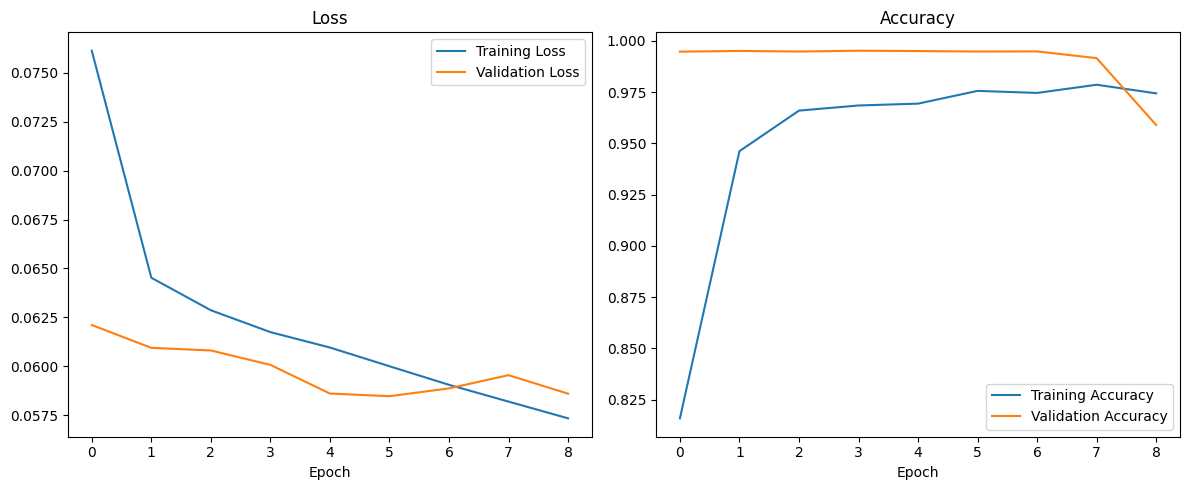

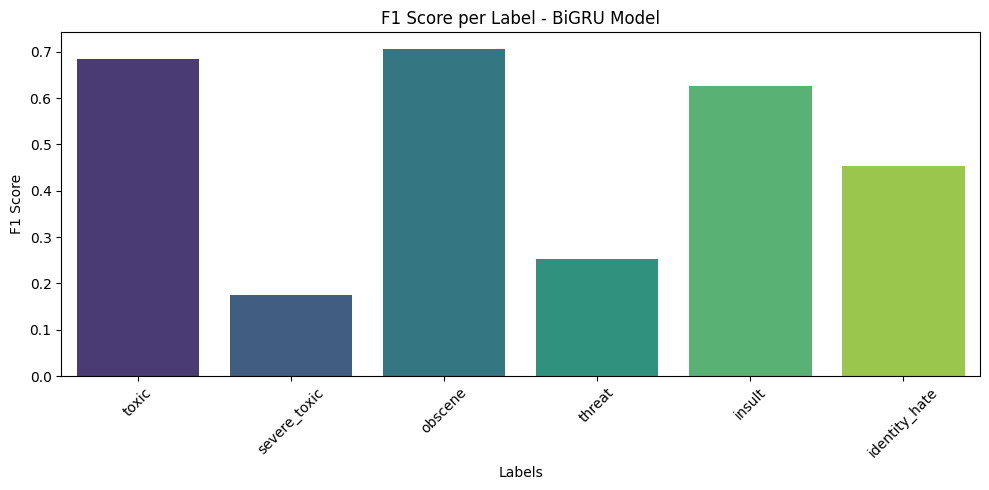

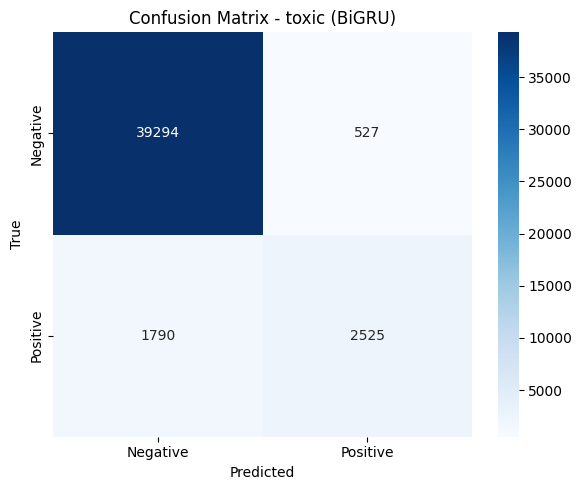

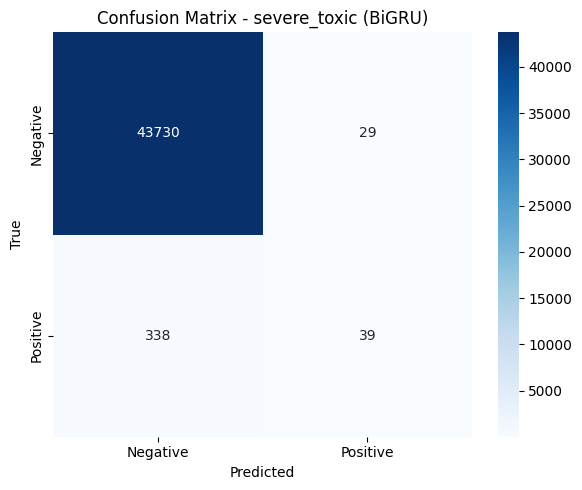

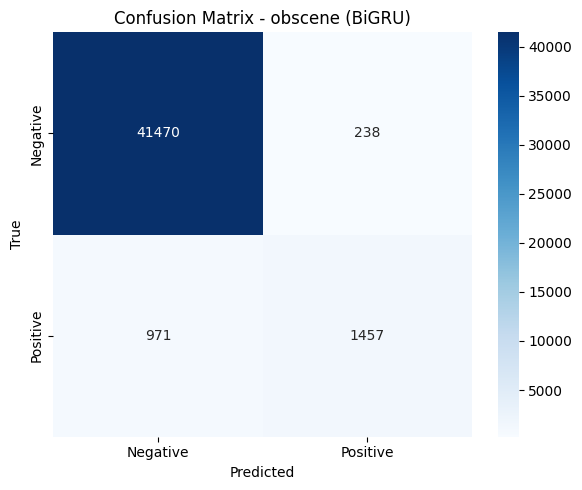

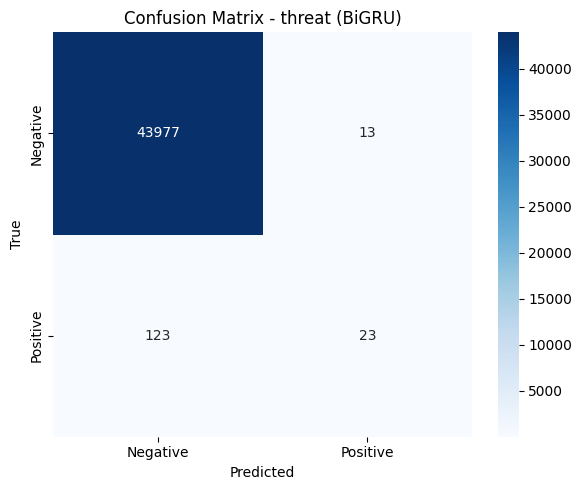

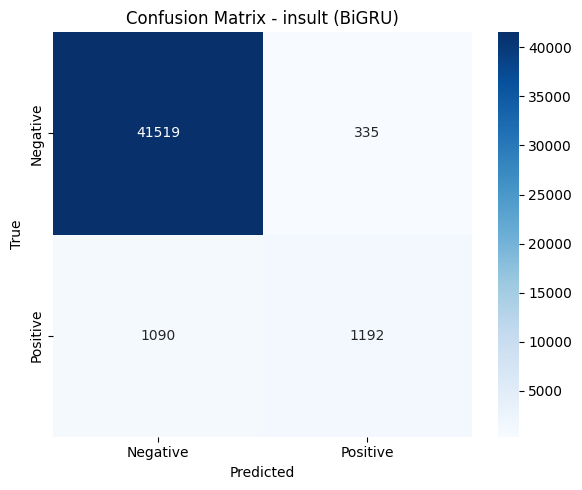

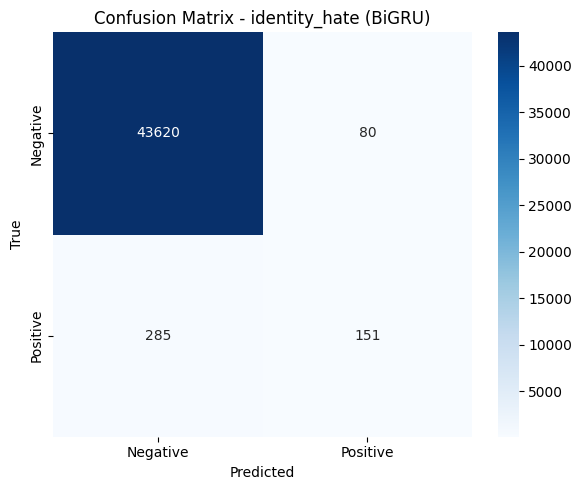

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow.tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, confusion_matrix
from tqdm import tqdm
import gc

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory config error: {e}")

mlflow.set_experiment("BiGRU-Toxic-Comment-Classification")

X = np.stack(df['vector'].to_numpy())
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

input_dim = X_train.shape[1]

class TqdmProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(TqdmProgressCallback, self).__init__()
        self.epochs = epochs
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.epochs, desc="Training BiGRU")

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        metrics_str = " - ".join([f"{k}: {v:.4f}" for k, v in logs.items()])
        self.pbar.set_postfix_str(metrics_str)

    def on_train_end(self, logs=None):
        self.pbar.close()

class MemoryManagementCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

hyperparameters = [
    {"gru_units": 128, "dropout": 0.3, "learning_rate": 0.001},
    {"gru_units": 256, "dropout": 0.5, "learning_rate": 0.0005}
]

with mlflow.start_run(run_name="BiGRU-Grid-Search"):
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(hyperparameters):
        print(f"Training BiGRU model {i+1}/{len(hyperparameters)} with params: {params}")

        with mlflow.start_run(run_name=f"BiGRU-Run-{i+1}", nested=True):
            tf.keras.backend.clear_session()

            mlflow.log_params(params)

            model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(input_dim,)),
                tf.keras.layers.Reshape((1, input_dim)),
                tf.keras.layers.Bidirectional(tf.keras.layers.GRU(params["gru_units"], return_sequences=True)),
                tf.keras.layers.Bidirectional(tf.keras.layers.GRU(params["gru_units"])),
                tf.keras.layers.Dropout(params["dropout"]),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(params["dropout"]),
                tf.keras.layers.Dense(6, activation='sigmoid')
            ])

            optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
            )

            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True
            )
            tqdm_callback = TqdmProgressCallback(epochs=30)
            memory_callback = MemoryManagementCallback()

            epochs = 100
            batch_size = 64

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping, tqdm_callback, memory_callback],
                verbose=0
            )

            val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)

            for epoch, metrics in enumerate(zip(history.history['loss'],
                                             history.history['accuracy'],
                                             history.history['auc'],
                                             history.history['val_loss'],
                                             history.history['val_accuracy'],
                                             history.history['val_auc'])):
                mlflow.log_metrics({
                    "loss": metrics[0],
                    "accuracy": metrics[1],
                    "auc": metrics[2],
                    "val_loss": metrics[3],
                    "val_accuracy": metrics[4],
                    "val_auc": metrics[5]
                }, step=epoch)


            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_params = params

            gc.collect()

    mlflow.log_params(best_params)  # Logging best hyperparameters
    print("Best BiGRU model parameters:", best_params)

    y_pred_prob = best_model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)

    test_loss, test_acc, test_auc = best_model.evaluate(X_test, y_test, verbose=0)
    hl = hamming_loss(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)

    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("hamming_loss", hl)

    for label in labels:
        mlflow.log_metric(f"f1_{label}", report[label]["f1-score"])

    mlflow.tensorflow.log_model(best_model, "bigru_model")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.savefig("bigru_training_history.png")
    mlflow.log_artifact("bigru_training_history.png")

    f1_scores = [report[label]["f1-score"] for label in labels]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=f1_scores, palette="viridis")
    plt.xlabel("Labels")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Label - BiGRU Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("bigru_f1_scores.png")
    mlflow.log_artifact("bigru_f1_scores.png")

    for i, label in enumerate(labels):
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {label} (BiGRU)')
        plt.tight_layout()
        cm_filename = f"bigru_confusion_matrix_{label}.png"
        plt.savefig(cm_filename)
        mlflow.log_artifact(cm_filename)

    tf.keras.backend.clear_session()
    gc.collect()

Num GPUs Available: 1
GPU memory config error: Physical devices cannot be modified after being initialized


2025/03/30 02:33:44 INFO mlflow.tracking.fluent: Experiment with name 'Transformer-Toxic-Comment-Classification' does not exist. Creating a new experiment.


Training Transformer model 1/2 with params: {'embed_dim': 128, 'head_size': 64, 'num_heads': 2, 'ff_dim': 128, 'num_transformer_blocks': 2, 'mlp_units': [64], 'dropout': 0.1, 'mlp_dropout': 0.2, 'learning_rate': 0.001}


Training Transformer:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
Training Transformer:  40%|████      | 12/30 [06:32<09:49, 32.72s/it, accuracy: 0.9944 - auc: 0.9822 - loss: 0.0521 - val_accuracy: 0.9952 - val_auc: 0.9680 - val_loss: 0.0613 - learning_rate: 0.0001]


🏃 View run Transformer-Run-1 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/12/runs/787685b3ccae4eed99398aa2b3ffeb8c
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/12
Training Transformer model 2/2 with params: {'embed_dim': 256, 'head_size': 64, 'num_heads': 4, 'ff_dim': 256, 'num_transformer_blocks': 3, 'mlp_units': [128, 64], 'dropout': 0.2, 'mlp_dropout': 0.3, 'learning_rate': 0.0005}


Training Transformer:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
Training Transformer:  40%|████      | 12/30 [07:21<11:01, 36.75s/it, accuracy: 0.9947 - auc: 0.9719 - loss: 0.0618 - val_accuracy: 0.9952 - val_auc: 0.9711 - val_loss: 0.0669 - learning_rate: 0.0001]


🏃 View run Transformer-Run-2 at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/12/runs/de070df887c74b778302168bc85b4508
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/12
Best Transformer model parameters: {'embed_dim': 128, 'head_size': 64, 'num_heads': 2, 'ff_dim': 128, 'num_transformer_blocks': 2, 'mlp_units': [64], 'dropout': 0.1, 'mlp_dropout': 0.2, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metri

Transformer model training complete. Best validation loss: 0.0590
Test metrics - Loss: 0.0602, Accuracy: 0.9954, AUC: 0.9736, Hamming Loss: 0.0224
🏃 View run Transformer-Grid-Search at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/12/runs/40c36b56501440b3bb9313f08adb8c6a
🧪 View experiment at: https://dagshub.com/Shrijeet14/toxic-comment-classification.mlflow/#/experiments/12


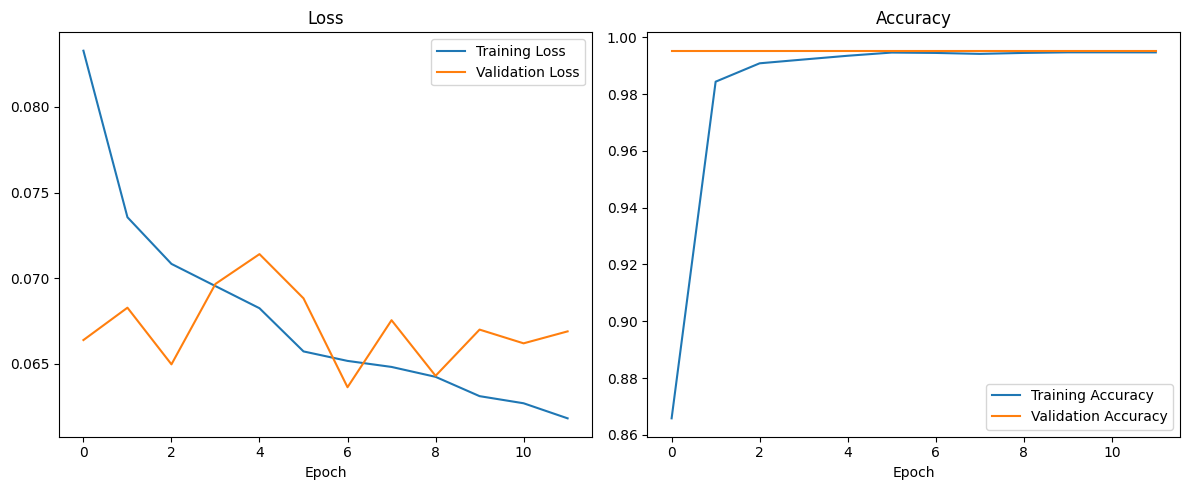

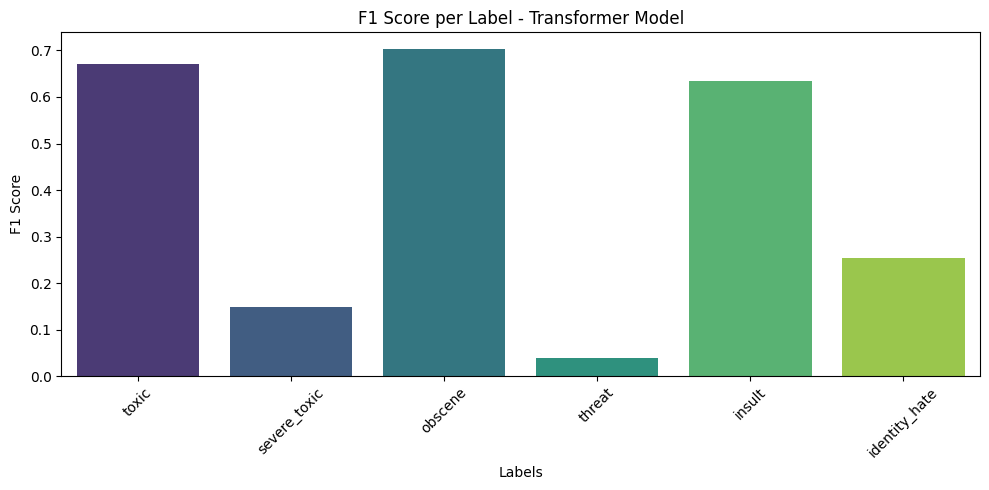

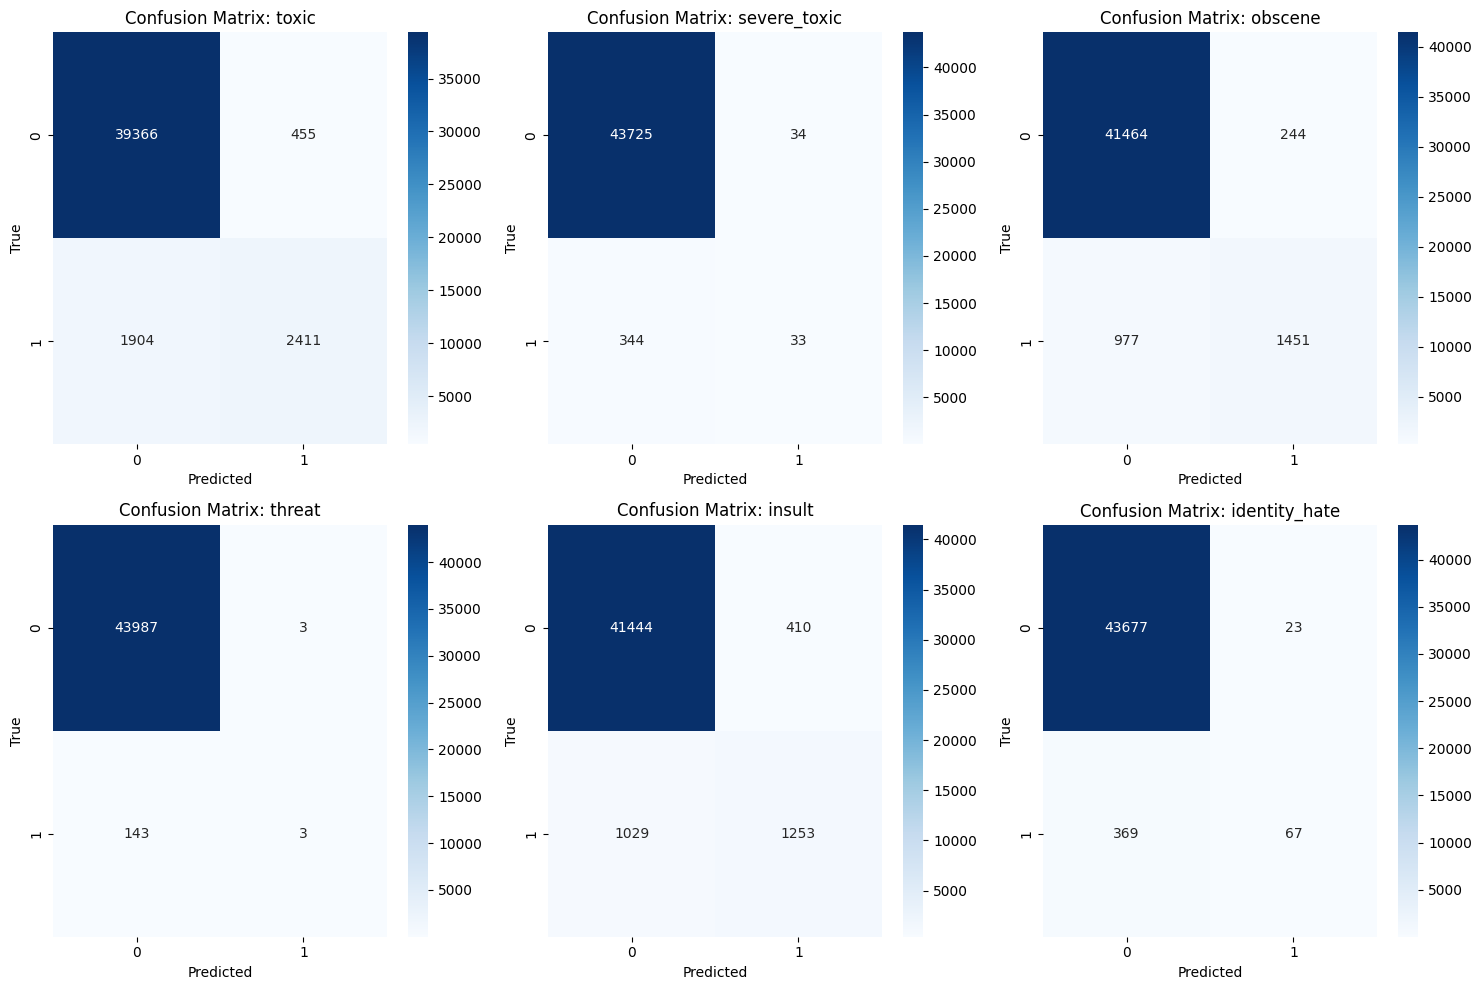

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow.tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, confusion_matrix
from tqdm import tqdm
import gc
import json


print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory config error: {e}")


mlflow.set_experiment("Transformer-Toxic-Comment-Classification")


X = np.stack(df['vector'].to_numpy())
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


input_dim = X_train.shape[1]


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = tf.keras.layers.Add()([x, inputs])

    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return tf.keras.layers.Add()([x, res])

class TqdmProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(TqdmProgressCallback, self).__init__()
        self.epochs = epochs
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.epochs, desc="Training Transformer")

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        metrics_str = " - ".join([f"{k}: {v:.4f}" for k, v in logs.items()])
        self.pbar.set_postfix_str(metrics_str)

    def on_train_end(self, logs=None):
        self.pbar.close()

class MemoryManagementCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()


def build_transformer_model(embed_dim, head_size, num_heads, ff_dim, num_transformer_blocks,
                           mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Reshape((1, input_dim))(inputs)
    x = tf.keras.layers.Dense(embed_dim)(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)

    outputs = tf.keras.layers.Dense(6, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

hyperparameters = [
    {
        "embed_dim": 128,
        "head_size": 64,
        "num_heads": 2,
        "ff_dim": 128,
        "num_transformer_blocks": 2,
        "mlp_units": [64],
        "dropout": 0.1,
        "mlp_dropout": 0.2,
        "learning_rate": 0.001
    },
    {
        "embed_dim": 256,
        "head_size": 64,
        "num_heads": 4,
        "ff_dim": 256,
        "num_transformer_blocks": 3,
        "mlp_units": [128, 64],
        "dropout": 0.2,
        "mlp_dropout": 0.3,
        "learning_rate": 0.0005
    }
]

with mlflow.start_run(run_name="Transformer-Grid-Search"):
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(hyperparameters):
        print(f"Training Transformer model {i+1}/{len(hyperparameters)} with params: {params}")

        with mlflow.start_run(run_name=f"Transformer-Run-{i+1}", nested=True):
            tf.keras.backend.clear_session()

            mlflow.log_params(params)

            model = build_transformer_model(
                params["embed_dim"],
                params["head_size"],
                params["num_heads"],
                params["ff_dim"],
                params["num_transformer_blocks"],
                params["mlp_units"],
                params["dropout"],
                params["mlp_dropout"]
            )

            optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
            )

            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=5, restore_best_weights=True
            )
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6
            )
            tqdm_callback = TqdmProgressCallback(epochs=30)
            memory_callback = MemoryManagementCallback()

            epochs = 100
            batch_size = 32

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping, reduce_lr, tqdm_callback, memory_callback],
                verbose=0
            )

            val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)

            for epoch, metrics in enumerate(zip(history.history['loss'],
                                             history.history['accuracy'],
                                             history.history['auc'],
                                             history.history['val_loss'],
                                             history.history['val_accuracy'],
                                             history.history['val_auc'])):
                mlflow.log_metrics({
                    "loss": metrics[0],
                    "accuracy": metrics[1],
                    "auc": metrics[2],
                    "val_loss": metrics[3],
                    "val_accuracy": metrics[4],
                    "val_auc": metrics[5]
                }, step=epoch)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_params = params

            gc.collect()

    print("Best Transformer model parameters:", best_params)

    y_pred_prob = best_model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)

    test_loss, test_acc, test_auc = best_model.evaluate(X_test, y_test, verbose=0)
    hl = hamming_loss(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)

    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("hamming_loss", hl)

    for label in labels:
        mlflow.log_metric(f"f1_{label}", report[label]["f1-score"])

    mlflow.tensorflow.log_model(best_model, "transformer_model")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.savefig("transformer_training_history.png")
    mlflow.log_artifact("transformer_training_history.png")

    f1_scores = [report[label]["f1-score"] for label in labels]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=f1_scores, palette="viridis")
    plt.xlabel("Labels")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Label - Transformer Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("transformer_f1_scores.png")
    mlflow.log_artifact("transformer_f1_scores.png")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, label in enumerate(labels):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.savefig("transformer_confusion_matrices.png")
    mlflow.log_artifact("transformer_confusion_matrices.png")

    mlflow.log_params({
        "best_embed_dim": best_params["embed_dim"],
        "best_head_size": best_params["head_size"],
        "best_num_heads": best_params["num_heads"],
        "best_ff_dim": best_params["ff_dim"],
        "best_num_transformer_blocks": best_params["num_transformer_blocks"],
        "best_mlp_units": str(best_params["mlp_units"]),
        "best_dropout": best_params["dropout"],
        "best_mlp_dropout": best_params["mlp_dropout"],
        "best_learning_rate": best_params["learning_rate"]
    })



    performance_summary = {
        "model_type": "Transformer",
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "test_auc": test_auc,
        "hamming_loss": hl,
        "macro_f1": report["macro avg"]["f1-score"],
        "weighted_f1": report["weighted avg"]["f1-score"]
    }

    with open("transformer_performance_summary.json", "w") as f:
        json.dump(performance_summary, f)

    mlflow.log_artifact("transformer_performance_summary.json")

    print(f"Transformer model training complete. Best validation loss: {best_val_loss:.4f}")
    print(f"Test metrics - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}, Hamming Loss: {hl:.4f}")